# Combining Review Text Content and User Similarity Matrix to Predict Review Rating

In this notebook we will be documenting our attempt of following the work done in [this](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4735905/) research published by Bingkun Wang, Yongfeng Huang, and Xing Li at Computational Intelligence and Neuroscience Journal.


*The data*

Our dataset is the Amazon baby products reviews dataset that was released by Amazon and can be found [here](http://jmcauley.ucsd.edu/data/amazon/links.html). At this point I want to thank Julian McAuley, assistant professor at UCSD, for his help with getting the data. In addition, we are thankful to Mandeep Kaur for the great work he did formerly with the Amazon DB.

*The Thesis*

We will try to prove that combining the formerly known data about each user's similarity to other users, with the sentiment analysis of the review text itself, will help us improve the model prediction of what rate the user's review will get.


*The workflow*

As a first step, we will perform Review Rating Prediction (hence forward will be referred as RRP) based on Review Text Content (RTC) on our data.
The next step will be to apply a neighbors analysis to perform RRP based on the similarity between users.
Finally, we will compare the three methods (RRP based on RTC, RRP based on neighbors analysis and the combination of the two) and declare the best method.

### Getting started

Some necessary imports

In [2]:
import numpy as np
import pandas as pd
import datetime
import calendar
import string
from scipy import sparse
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import neighbors
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    from sklearn import cross_validation
    
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline

The data from the link above comes in json files. Here we already opened and converted the files to a simple csv files. If youre having difficulties with it, do contact us at Yereya.b@Gmail.com and we will gladly send you the code we used.

In [3]:
reviews_df = pd.read_csv('reviews_df.csv')
backup1 = reviews_df.copy()

In [4]:
reviews_df.info()
reviews_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160792 entries, 0 to 160791
Data columns (total 10 columns):
Unnamed: 0        160792 non-null int64
reviewerID        160792 non-null object
asin              160792 non-null object
reviewerName      159427 non-null object
helpful           160792 non-null object
reviewText        160732 non-null object
overall           160792 non-null float64
summary           160792 non-null object
unixReviewTime    160792 non-null int64
reviewTime        160792 non-null object
dtypes: float64(1), int64(2), object(7)
memory usage: 12.3+ MB


,Unnamed: 0,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,0,A1HK2FQW6KXQB2,097293751X,"Amanda Johnsen ""Amanda E. Johnsen""","[0, 0]",Perfect for new parents. We were able to keep ...,5.0,Awesine,1373932800,"07 16, 2013"
1,1,A19K65VY14D13R,097293751X,angela,"[0, 0]",This book is such a life saver. It has been s...,5.0,Should be required for all new parents!,1372464000,"06 29, 2013"
2,2,A2LL1TGG90977E,097293751X,Carter,"[0, 0]",Helps me know exactly how my babies day has go...,5.0,Grandmother watching baby,1395187200,"03 19, 2014"
3,3,A5G19RYX8599E,097293751X,cfpurplerose,"[0, 0]",I bought this a few times for my older son and...,5.0,repeat buyer,1376697600,"08 17, 2013"
4,4,A2496A4EWMLQ7,097293751X,C. Jeter,"[0, 0]",I wanted an alternative to printing out daily ...,4.0,Great,1396310400,"04 1, 2014"


### Preprocessing


In [5]:
reviews_df = reviews_df[~pd.isnull(reviews_df['reviewText'])] # Deleting all the lines that has no reviewText
reviews_df.drop_duplicates(subset=['reviewerID', 'asin', 'unixReviewTime'], inplace=True)
reviews_df.drop('Unnamed: 0', axis=1, inplace=True)
reviews_df.reset_index(inplace=True)

reviews_df['helpful_numerator'] = reviews_df['helpful'].apply(lambda x: eval(x)[0])
reviews_df['helpful_denominator'] = reviews_df['helpful'].apply(lambda x: eval(x)[1])
reviews_df['helpful%'] = np.where(reviews_df['helpful_denominator'] > 0,
                                  reviews_df['helpful_numerator'] / reviews_df['helpful_denominator'], -1)

# Now to segment the values into bins
reviews_df['helpfulness_range'] = pd.cut(x=reviews_df['helpful%'], bins=[-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0],
                                         labels=['empty', '1', '2', '3', '4', '5'], include_lowest=True)
# org_reviews_df = reviews_df.copy()

reviews_df.drop(reviews_df[reviews_df['helpfulness_range'] == 'empty'].index, inplace=True)
reviews_df['helpfulness_range'] = reviews_df['helpfulness_range'].map({'1':1,
                                                                       '2':2,
                                                                       '3':3,
                                                                       '4':4,
                                                                       '5':5,
                                                                       'empty':1})
reviews_df.reset_index(drop=True, inplace=True)

### EDA


In [6]:
a = list(calendar.day_name)
reviews_df['review_weekday'] = reviews_df['reviewTime'].apply(lambda x: datetime.datetime.strptime(str(x),'%m %d, %Y').weekday())
reviews_df['review_weekday'] = reviews_df['review_weekday'].apply(lambda x: a[x])

print(reviews_df.groupby('review_weekday')['helpful%'].mean())

review_weekday
Friday       0.845707
Monday       0.842031
Saturday     0.841442
Sunday       0.846644
Thursday     0.842822
Tuesday      0.843771
Wednesday    0.841654
Name: helpful%, dtype: float64


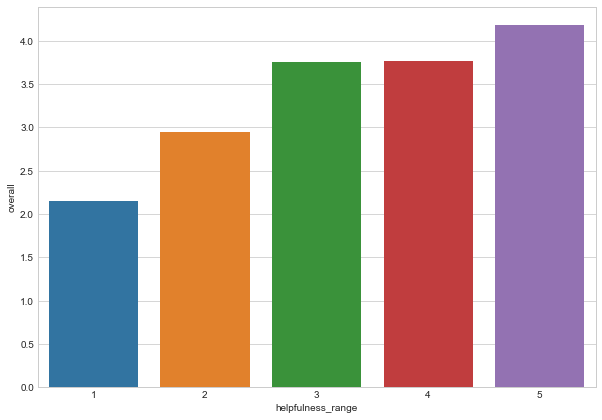

In [22]:
df1 = pd.DataFrame(reviews_df.groupby('helpfulness_range')['overall'].mean().reset_index())
fig = plt.figure(figsize=(10,7))
sns.barplot(x=df1['helpfulness_range'], y=df1['overall']) # there is a connection between high overall score and review score

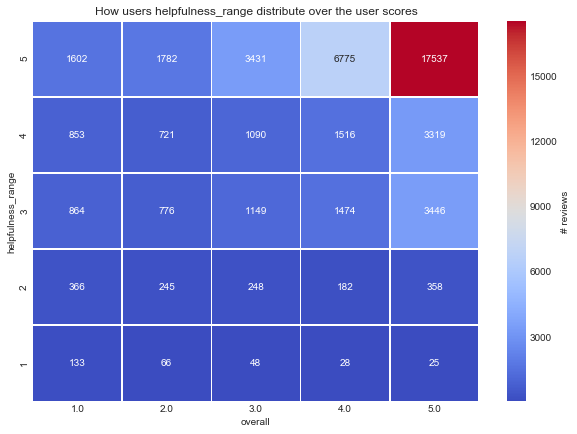

In [27]:
df1 = reviews_df.groupby(['overall', 'helpfulness_range']).agg({'reviewerID': 'count'})
df1 = df1.unstack()
df1.columns = df1.columns.get_level_values(1)
fig = plt.figure(figsize=(10,7))
sns.heatmap(df1[df1.columns[::-1]].T, cmap = 'coolwarm', linewidths=.5, annot = True, fmt = 'd', cbar_kws={'label': '# reviews'})
plt.title('How users helpfulness_range distribute over the user scores')
plt.show()

## RRP based on Review Text Content
### Feature Engineering


In [30]:
reviews_df['helpfulness_range'].value_counts()

5    31127
3     7709
4     7499
2     1399
1      300
Name: helpfulness_range, dtype: int64

Notice that the data is really skewed, that means consider resampling!

Now to define our text processor

In [31]:
def text_process(reviewText):
    nopunc = [i for i in reviewText if i not in string.punctuation]
    nopunc_text = ''.join(nopunc)
    return [i for i in nopunc_text.split() if i.lower() not in stopwords.words('english')]

### The Models


We will write down the code for all of the models but, becouse of the long time it will take them to run, we will not run them. Instead, we will copy the results from our PyCharm.

We encourage you to run the code on your computer and check to see if you get the same results as us.

In [ ]:
# Benchmark model - multinomial logistic regression
pipeline = Pipeline([
    ('Tf-Idf', TfidfVectorizer(ngram_range=(1,2), analyzer=text_process)),
    ('classifier', LogisticRegression(solver='newton-cg', multi_class='multinomial'))
])
X1 = reviews_df['reviewText']
y1 = reviews_df['helpfulness_range']
review_train1, review_test1, label_train1, label_test1 = train_test_split(X1, y1, test_size=0.3, random_state=101)
pipeline.fit(review_train1, label_train1)
pip_pred1 = pipeline.predict(review_test1)
print(metrics.classification_report(label_test1,pip_pred1))

In [ ]:
# First model try - Naive bayes
pipeline = Pipeline([
    ('Tf-Idf', TfidfVectorizer(ngram_range=(1,2), analyzer=text_process)),
    ('classifier', MultinomialNB())
])
X2 = reviews_df['reviewText']
y2 = reviews_df['helpfulness_range']
review_train2, review_test2, label_train2, label_test2 = train_test_split(X2, y2, test_size=0.5)
pipeline.fit(review_train2, label_train2)
pip_pred2 = pipeline.predict(review_test2)
print(metrics.classification_report(label_test2, pip_pred2))

In [ ]:
# DecisionTreeClassifier
pipeline = Pipeline([
    ('Tf-Idf', TfidfVectorizer(ngram_range=(1,2), analyzer=text_process)),
    ('classifier', DecisionTreeClassifier())
])
X3 = reviews_df['reviewText']
y3 = reviews_df['helpfulness_range']
review_train3, review_test3, label_train3, label_test3 = train_test_split(X3, y3, test_size=0.5)
pipeline.fit(review_train3, label_train3)
pip_pred3 = pipeline.predict(review_test3)
print(metrics.classification_report(label_test3, pip_pred3))

In [ ]:
# RandomForest
pipeline = Pipeline([
    ('Tf-Idf', TfidfVectorizer(ngram_range=(1,2), analyzer=text_process)),
    ('classifier', RandomForestClassifier())
])
X4 = reviews_df['reviewText']
y4 = reviews_df['helpfulness_range']
review_train4, review_test4, label_train4, label_test4 = train_test_split(X4, y4, test_size=0.5)
pipeline.fit(review_train4, label_train4)
pip_pred4 = pipeline.predict(review_test4)
print(metrics.classification_report(label_test4, pip_pred4))

#### Scores

(You should run this after each pipline)

In [ ]:
scores = cross_validation.cross_val_score(pipeline, reviews_df['reviewText'], reviews_df['helpfulness_range'], cv=5)
print(scores.mean())

**RandomForest rank 0.59, MultinomialNB rank 0.61, DecisionTreeClassifier rank 0.44**

So we will use the MultinomialNB prediction as our chosen prediction that was based on Review Text Content.

#### Export

In [ ]:
rev_test_pred_NB_df = pd.DataFrame(data={'review_test': review_test2,
                                         'prediction': pip_pred2})
rev_test_pred_NB_df.to_csv('rev_test_pred_NB_df.csv')

## RRP based on User Similarity
### Preprocessing


In [35]:
reviewers_rating_df = reviews_df[['reviewerID', 'asin', 'overall', 'helpfulness_range']].copy()
reviewers_rating_df['overall'] = reviewers_rating_df['overall'].apply(int)

# we need to convert the string names of reviewerID and asin to unique integers before we can generate a matrix

temp_df = pd.DataFrame(np.unique(reviewers_rating_df['reviewerID']), columns=['unique_ID'])
temp_df['unique_asin'] = pd.Series(np.unique(reviewers_rating_df['asin']))
temp_df['unique_ID_int'] = range(20000, 35998)
temp_df['unique_asin_int'] = range(1, 15999)

reviewers_rating_df = pd.merge(reviewers_rating_df, temp_df.drop(['unique_asin', 'unique_asin_int'], axis=1),
                               left_on='reviewerID', right_on='unique_ID')
reviewers_rating_df = pd.merge(reviewers_rating_df, temp_df.drop(['unique_ID', 'unique_ID_int'], axis=1),
                               left_on='asin', right_on='unique_asin')

reviewers_rating_df['overall_rating'] = reviewers_rating_df['overall']
id_asin_helpfulness_df = reviewers_rating_df[['reviewerID', 'unique_ID_int', 'helpfulness_range']].copy()
reviewers_rating_df.drop(['asin', 'unique_asin', 'reviewerID', 'unique_ID', 'overall', 'helpfulness_range'], axis=1, inplace=True)

### Feature Engineering

In [ ]:
matrix = reviewers_rating_df.pivot(index='unique_ID_int', columns='unique_asin_int', values='overall_rating')
matrix = matrix.fillna(0)
user_item_matrix = sparse.csr_matrix(matrix.values)

### KNN Model


Again, we will not run the model. Instead, we will use the results from our PyCharm.

In [ ]:
model_knn = neighbors.NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10)
model_knn.fit(user_item_matrix)
neighbors = np.asarray(model_knn.kneighbors(user_item_matrix, return_distance=False))

In [ ]:
unique_id = []
k_neigh = []
for i in range(15998):
    unique_id.append(i + 20000)
    k_neigh.append(list(neighbors[i][1:10])) #Grabbing the ten closest neighbors

neighbors_df = pd.DataFrame(data={'unique_ID_int': unique_id,
                                  'k_neigh': k_neigh})

id_asin_helpfulness_df = pd.merge(id_asin_helpfulness_df, neighbors_df, on='unique_ID_int')
id_asin_helpfulness_df['neigh_based_helpf'] = id_asin_helpfulness_df['unique_ID_int']

In [ ]:
# Calculating the mean score of the reviews that the reviewers in 'k_neigh' wrote
for index, row in id_asin_helpfulness_df.iterrows():
    row = row['k_neigh']
    lista = []
    for i in row:
        p = id_asin_helpfulness_df.loc[i]['helpfulness_range']
        lista.append(p)
    id_asin_helpfulness_df.loc[index, 'neigh_based_helpf'] = np.nanmean(lista)

#### Export

In [ ]:
final_df = id_asin_helpfulness_df[['reviewerID', 'unique_ID_int', 'helpfulness_range', 'neigh_based_helpf']]
final_df.to_csv('final.csv')

## Reporting the results

We merged the two dataframes in the background. Email us if you need the code to do so.

In [38]:
df = pd.read_csv('final_after_merges.csv')
print('RMSE for neigh_based_helpf:', np.sqrt(mean_squared_error(df['helpfulness_range'], df['neigh_based_helpf'])))
print('RMSE for NBprediction:', np.sqrt(mean_squared_error(df['helpfulness_range'], df['NBprediction'])))
print('RMSE for the combination of the twe methods:', np.sqrt(mean_squared_error(df['helpfulness_range'], df['mean_neigh_NB'])))
print('MAE for the combined prediction:', mean_absolute_error(df['helpfulness_range'], df['mean_neigh_NB']))

RMSE for neigh_based_helpf: 1.0338002581383618
RMSE for NBprediction: 1.074619472976386
RMSE for the combination of the twe methods: 0.9920521481819871
MAE for the combined prediction: 0.6618020568763793


As it turns out, **our thesis was right** and combining the formerly known data about each user's similarity to other users, with the sentiment analysis of the review text itself, does help improve the model prediction of what rate the user's review will get.

(Although MAE of 0.66 is not so good here, the main aim of this work was to check the thesis. Not necessarily to seek the best RRP model)